###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 2: Duration Classification with Recipe Data


**Student ID(s): 1004503, 1005418

## Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#import pickle
import scipy
import gc
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Pre-process for count vectorizer and doc2vec

In [ ]:
# Count Vectoriser process

count_vec_name = scipy.sparse.load_npz("ML2_data/recipe_text_features_countvec/train_name_vec.npz").toarray().astype('float32')
count_vec_steps = scipy.sparse.load_npz("ML2_data/recipe_text_features_countvec/train_steps_vec.npz").toarray().astype('float32')
count_vec_ingr = scipy.sparse.load_npz("ML2_data/recipe_text_features_countvec/train_ingr_vec.npz").toarray().astype('float32')

test_count_vec_name = scipy.sparse.load_npz("ML2_data/recipe_text_features_countvec/test_name_vec.npz").toarray().astype('float32')
test_count_vec_steps = scipy.sparse.load_npz("ML2_data/recipe_text_features_countvec/test_steps_vec.npz").toarray().astype('float32')
test_count_vec_ingr = scipy.sparse.load_npz("ML2_data/recipe_text_features_countvec/test_ingr_vec.npz").toarray().astype('float32')

In [ ]:
# Doc2vec process

doc2vec100_name = pd.read_csv("ML2_data/recipe_text_features_doc2vec100/train_name_doc2vec100.csv", header = None).values.astype('float32')
doc2vec100_steps = pd.read_csv("ML2_data/recipe_text_features_doc2vec100/train_steps_doc2vec100.csv", header = None).values.astype('float32')
doc2vec100_ingr = pd.read_csv("ML2_data/recipe_text_features_doc2vec100/train_ingr_doc2vec100.csv", header = None).values.astype('float32')

test_doc2vec100_name = pd.read_csv("ML2_data/recipe_text_features_doc2vec100/test_name_doc2vec100.csv", header = None).values.astype('float32')
test_doc2vec100_steps = pd.read_csv("ML2_data/recipe_text_features_doc2vec100/test_steps_doc2vec100.csv", header = None).values.astype('float32')
test_doc2vec100_ingr = pd.read_csv("ML2_data/recipe_text_features_doc2vec100/test_ingr_doc2vec100.csv", header = None).values.astype('float32')


## Extract data from recipe csv

In [ ]:

csv_data = pd.read_csv("ML2_data/recipe_train.csv")
test_csv_data = pd.read_csv("ML2_data/recipe_test.csv")

n_steps = csv_data.iloc[:,1]
n_steps = n_steps.values

n_ingr = csv_data.iloc[:,2]
n_ingr = n_ingr.values

test_n_steps = test_csv_data.iloc[:,1]
test_n_steps = test_n_steps.values

test_n_ingr =  test_csv_data.iloc[:,2]
test_n_ingr =  test_n_ingr.values

duration_array = csv_data.iloc[:,-1]
duration_array = duration_array.values

n_steps_array = []
n_ingr_array = []

test_n_steps_array = []
test_n_ingr_array = []

for i in range(len(n_steps)):
    n_steps_array.append([n_steps[i]])
    n_ingr_array.append([n_ingr[i]])
    
for i in range(len(test_n_steps)):
    test_n_steps_array.append([test_n_steps[i]])
    test_n_ingr_array.append([test_n_ingr[i]])


In [ ]:
train_data = np.hstack([n_steps_array,
                        n_ingr_array,
                        doc2vec100_name,
                        doc2vec100_steps,
                        doc2vec100_ingr,
                        count_vec_name, 
                        count_vec_steps, 
                        count_vec_ingr])

test_data = np.hstack([ test_n_steps_array,
                        test_n_ingr_array,
                        test_doc2vec100_name,
                        test_doc2vec100_steps,
                        test_doc2vec100_ingr,
                        test_count_vec_name, 
                        test_count_vec_steps, 
                        test_count_vec_ingr])

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

print(train_data.shape)



In [ ]:
 #X_train, X_test, y_train, y_test = train_test_split(train_data, duration_array, test_size=0.25, random_state=42)

In [ ]:
 X_train, X_test, y_train = train_data, test_data, duration_array

In [ ]:
#del test_n_steps_array
#del test_n_ingr_array
#del test_doc2vec100_name
#del test_doc2vec100_steps
#del test_doc2vec100_ingr
#del test_count_vec_name
#del test_count_vec_steps
#del test_count_vec_ingr

In [ ]:
abs_scaler = preprocessing.MaxAbsScaler()

X_train = abs_scaler.fit_transform(X_train)
X_test = abs_scaler.fit_transform(X_test)


In [ ]:
#gc.collect()

In [ ]:
selection = SelectKBest(score_func=f_classif, k=500)
selection.fit(X_train,y_train)
new_X_train = selection.transform(X_train)
new_X_test = selection.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn import svm
import time

#try different classifiers and evaluate individual model performance
#code adapated from Practical 8

models = [LogisticRegression(),
          GaussianNB(),
          svm.LinearSVC(),
          DecisionTreeClassifier()]

titles = ['Logistic Regression',
          'GNB',
          'LinearSVC',
          'Decision Tree']

for title, model in zip(titles, models):
    
     output = []
     model.fit(new_X_train, y_train)
     y_predict = model.predict(new_X_test)
     
     for i in range(len(y_predict)):
         row = [i+1, y_predict[i]]
         output.append(row)
   
     output = pd.DataFrame(output, columns = ['id', 'duration_label'])
     output.to_csv(title + '_CV.csv', index = False)

# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))


In [ ]:
xgb = XGBClassifier(tree_method='gpu_hist')

output = []
xgb.fit(new_X_train, y_train)

y_predict = xgb.predict(new_X_test)

for i in range(len(y_predict)):
    row = [i+1, y_predict[i]]
    output.append(row)
  
output = pd.DataFrame(output, columns = ['id', 'duration_label'])
output.to_csv('xgb'+ '_CV.csv', index = False)

In [ ]:
#implement stacker

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

models = [LogisticRegression(),
          XGBClassifier(tree_method='gpu_hist'),
          svm.LinearSVC(),
          DecisionTreeClassifier()]

titles = ['Logistic Regression',
          'XGB',
          'LinearSVC',
          'Decision Tree']

clf = StackingClassifier(
    estimators=list(zip(titles,models)), final_estimator=LogisticRegression()
     )

output = []
clf.fit(new_X_train, y_train)
y_predict = clf.predict(new_X_test)

for i in range(len(y_predict)):
    row = [i+1, y_predict[i]]
    output.append(row)
  
output = pd.DataFrame(output, columns = ['id', 'duration_label'])
output.to_csv('Stacker'+ '_CV.csv', index = False)

In [ ]:
#implement ADABoost

from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=300, random_state=0)

t_start = time.time()

clf.fit(new_X_train, y_train)
y_predict = clf.predict(new_X_test)
t_end = time.time()
output = []

for i in range(len(y_predict)):
    row = [i+1, y_predict[i]]
    output.append(row)
  
output = pd.DataFrame(output, columns = ['id', 'duration_label'])
output.to_csv('AdaBoost'+ '_CV.csv', index = False)

In [ ]:
#create train test split for model visualisations
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(train_data, duration_array, test_size=0.25, random_state=42)

In [ ]:
selection = SelectKBest(score_func=f_classif, k=500)
selection.fit(X_train,y_train)
new_X_train = selection.transform(X_train)
new_X_test = selection.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import wandb
wandb.init(project = "Recipe Duration Prediction")

svc = svm.LinearSVC(random_state=42)
lr = LogisticRegression(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
dt = DecisionTreeClassifier(random_state=42)

models = [svc, lr, rf, dt]

for model in models:
    model.fit(new_X_train, y_train)


In [ ]:
import warnings
import scikitplot as skplt
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

y_test_pred = lr.predict(new_X_test)

fig = plt.figure(figsize=(15,6))
                 
ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred,
                                    title="Logistic Regression",
                                    cmap="Oranges",
                                    ax=ax1)


In [ ]:

y_test_pred = lr.predict(new_X_test)

fig = plt.figure(figsize=(15,6))
                 
ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred,
                                    title="Logistic Regression",
                                    cmap="Oranges",
                                    ax=ax1)



<AxesSubplot:title={'center':'Decision Tree'}, xlabel='Predicted label', ylabel='True label'>

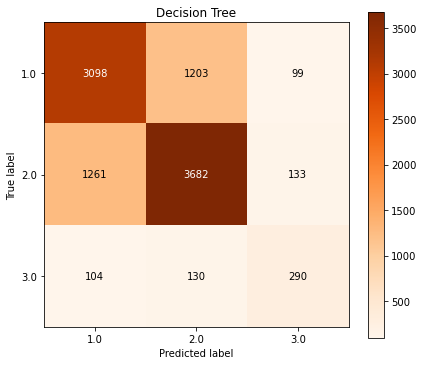

In [45]:
y_test_pred = dt.predict(new_X_test)

fig = plt.figure(figsize=(15,6))
                 
ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred,
                                    title="Decision Tree",
                                    cmap="Oranges",
                                    ax=ax1)



In [52]:
#preprocess entire data set
gc.collect()

2440

MemoryError: Unable to allocate 699. MiB for an array with shape (5715, 32067) and data type float32

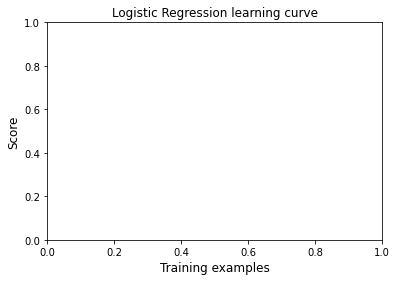

In [53]:
skplt.estimators.plot_learning_curve(LogisticRegression(), train_data, duration_array,
                                     cv=7, shuffle=True, scoring="accuracy",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Logistic Regression learning curve");